<a href="https://colab.research.google.com/github/DanieleBaiocco/IPCV_assignment2/blob/main/assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [3]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

Cloning into 'GroceryStoreDataset'...
remote: Enumerating objects: 6559, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 6559 (delta 45), reused 35 (delta 35), pack-reused 6293
Receiving objects: 100% (6559/6559), 116.26 MiB | 16.79 MiB/s, done.
Resolving deltas: 100% (275/275), done.


In [118]:
!pip install thop

In [4]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 11.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [109]:
from pathlib import Path
from PIL import Image
import PIL
import torch
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple, Callable, Optional
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm
import torchmetrics
from torchsummary import summary
import numpy as np
import random
import torchvision
import  matplotlib.pyplot as plt
import os
import copy
import pandas as pd

In [6]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform: Callable[[PIL.Image.Image], Tensor]) -> None:
        super().__init__()
        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]
        tensor_img = self.transform(img).float()
        return tensor_img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []
        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path)
                labels.append(int(label))
        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

In [7]:
random_state = 42
np.random.seed(random_state)
random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_state)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

PENSO CHE LA COSA MIGLIORE DA FARE SIA INIZIARE CON UN MODELLO MOLTO COMPLICATO CHE OVERFITTI SUL TRAINING DATA. A QUEL PUNTO INSERIRE DELLE REGULARIZATION TECNIQUES CHE MI FACCIANO ARRIVARE A UNA EFFECTIVE CAPACITY OTTIMALE.

In [ ]:
!pip install mypy
# Simple mypy cell magic for Colab
from IPython.core.magic import register_cell_magic
from IPython import get_ipython
from mypy import api

@register_cell_magic
def mypy(line, cell):
    for output in api.run(['-c', '\n' + cell] + line.split()):
        if output and not output.startswith('Success'):
            raise TypeError(output)
    get_ipython().run_cell(cell)

In [8]:
resize_size = 300
crop_size = 256

In [16]:
def base_transform(resize_size, crop_size):
    return transforms.Compose([transforms.Resize(resize_size),
                               transforms.CenterCrop(crop_size),
                               transforms.ToTensor()])
def train_transform(crop_size, mean, std):
    return transforms.Compose([transforms.RandomResizedCrop(crop_size),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=mean, std=std)])
def val_transform(resize_size, crop_size, mean, std):
    return transforms.Compose([transforms.Resize(resize_size),
                               transforms.CenterCrop(crop_size),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=mean, std=std)])

In [9]:
#%%mypy --ignore-missing-imports
def create_dataloader(split: str,
                      transform: Callable[[PIL.Image.Image],Tensor],
                      dataset_creation: Callable[[str, Callable[[PIL.Image.Image],Tensor]], Dataset],
                      batch_size: int,
                      shuffle: bool,
                      num_workers: int) -> DataLoader:
      dataset = dataset_creation(split, transform)
      return DataLoader(dataset, batch_size = batch_size, shuffle = shuffle, num_workers = num_workers)

In [11]:
def compute_sums(loader):
    sum_red = 0.0
    sum_green = 0.0
    sum_blue = 0.0
    num_pixels = 0

    for images, _ in loader:
        sum_red += images[:, 0, :, :].sum().item()
        sum_green += images[:, 1, :, :].sum().item()
        sum_blue += images[:, 2, :, :].sum().item()
        num_pixels += images[:, 0, :, :].numel()

    return sum_red, sum_green, sum_blue, num_pixels

def compute_means(sum_red, sum_green, sum_blue, num_pixels):
    mean_red = sum_red / num_pixels
    mean_green = sum_green / num_pixels
    mean_blue = sum_blue / num_pixels
    return mean_red, mean_green, mean_blue

def compute_sum_of_squared_diff(loader, mean_red, mean_green, mean_blue):
    sum_red_diff_sq = 0.0
    sum_green_diff_sq = 0.0
    sum_blue_diff_sq = 0.0

    for images, _ in loader:
        sum_red_diff_sq += ((images[:, 0, :, :] - mean_red) ** 2).sum().item()
        sum_green_diff_sq += ((images[:, 1, :, :] - mean_green) ** 2).sum().item()
        sum_blue_diff_sq += ((images[:, 2, :, :] - mean_blue) ** 2).sum().item()

    return sum_red_diff_sq, sum_green_diff_sq, sum_blue_diff_sq

def compute_std(sum_red_diff_sq, sum_green_diff_sq, sum_blue_diff_sq, num_pixels):
    std_red = (sum_red_diff_sq / num_pixels) ** 0.5
    std_green = (sum_green_diff_sq / num_pixels) ** 0.5
    std_blue = (sum_blue_diff_sq / num_pixels) ** 0.5
    return std_red, std_green, std_blue

In [12]:
def get_mean_and_std(loader):
    sum_red, sum_green, sum_blue, num_pixels = compute_sums(loader)
    mean_red, mean_green, mean_blue = compute_means(sum_red, sum_green, sum_blue, num_pixels)
    sum_red_diff_sq, sum_green_diff_sq, sum_blue_diff_sq = compute_sum_of_squared_diff(loader, mean_red, mean_green, mean_blue)
    std_red, std_green, std_blue = compute_std(sum_red_diff_sq, sum_green_diff_sq, sum_blue_diff_sq, num_pixels)
    return [mean_red, mean_green, mean_blue], [std_red, std_green, std_blue]

In [26]:
food_dict = {
    0: "Apple",
    1: "Avocado",
    2: "Banana",
    3: "Kiwi",
    4: "Lemon",
    5: "Lime",
    6: "Mango",
    7: "Melon",
    8: "Nectarine",
    9: "Orange",
    10: "Papaya",
    11: "Passion-Fruit",
    12: "Peach",
    13: "Pear",
    14: "Pineapple",
    15: "Plum",
    16: "Pomegranate",
    17: "Red-Grapefruit",
    18: "Satsumas",
    19: "Juice",
    20: "Milk",
    21: "Oatghurt",
    22: "Oat-Milk",
    23: "Sour-Cream",
    24: "Sour-Milk",
    25: "Soyghurt",
    26: "Soy-Milk",
    27: "Yoghurt",
    28: "Asparagus",
    29: "Aubergine",
    30: "Cabbage",
    31: "Carrots",
    32: "Cucumber",
    33: "Garlic",
    34: "Ginger",
    35: "Leek",
    36: "Mushroom",
    37: "Onion",
    38: "Pepper",
    39: "Potato",
    40: "Red-Beet",
    41: "Tomato",
    42: "Zucchini"
}

In [19]:
base_trainloader =  create_dataloader('train', base_transform(resize_size, crop_size), GroceryStoreDataset, batch_size = 64, shuffle = False, num_workers = 2)
mean, std = get_mean_and_std(base_trainloader)

In [42]:
class SqueezeDims(torch.nn.Module):
    def forward(self, x):
        return x.squeeze()

class GroceryStoreModel(torch.nn.Module):
    def __init__(self, act_layer: Callable[[], torch.nn.Module],
                 norm_layer: Callable[[int], torch.nn.Module],
                 stem_layer: Callable[[int, Callable, Callable, int], torch.nn.Sequential],
                 stage_layer: Callable[[int, Callable, Callable, int], torch.nn.Sequential],
                 dropout_head: float,
                 dropout_fe: float,
                 stem_out_channels: int,
                 num_stages: int,
                 num_classes: int):
        super(GroceryStoreModel, self).__init__()
        self.stem = torch.nn.Sequential(
            stem_layer(stem_out_channels, act_layer, norm_layer, dropout_fe),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.stages = torch.nn.ModuleList()
        in_channels = stem_out_channels
        for _ in range(num_stages):
            stage = stage_layer(in_channels, act_layer, norm_layer, dropout_fe)
            self.stages.append(stage)
            in_channels *= 2
        self.head = torch.nn.Sequential(
          torch.nn.AdaptiveAvgPool2d((1, 1)),
          SqueezeDims(),
          torch.nn.Dropout(dropout_head),
          torch.nn.Linear(in_channels, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.stem(x)
        for stage in self.stages:
            x = stage(x)
        x = self.head(x)
        return x

In [41]:
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels: int,
                 out_channels: int,
                 kernel_size: int,
                 stride: int,
                 padding: int,
                 act_layer: Callable[[], torch.nn.Module],
                 norm_layer: Callable[[int], torch.nn.Module],
                 dropout_rate: float):
        super(ConvBlock,self).__init__()
        self.conv2d = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.norm_layer = norm_layer(out_channels)
        self.act_layer = act_layer()
        self.dropout_rate = dropout_rate

    def forward(self,x):
        x = self.conv2d(x)
        x = self.norm_layer(x)
        x = self.act_layer(x)
        if self.dropout_rate>0:
          x = torch.nn.Dropout(self.dropout_rate)(x)
        return x

In [44]:
class InceptionBlock(torch.nn.Module):
    def __init__(self, in_channels: int,
                 out_channels: int,
                 act_layer: Callable[[], torch.nn.Module],
                 norm_layer: Callable[[int], torch.nn.Module],
                 dropout_rate: float):
        super(InceptionBlock,self).__init__()
        out_1x1 = out_channels // 4
        red_3x3 = out_1x1 // 2
        out_3x3 = out_1x1
        red_5x5 = out_1x1 // 2
        out_5x5 = out_1x1
        out_1x1_pooling = out_1x1
        # branch1 : k=1,s=1,p=0
        self.branch1 = ConvBlock(in_channels = in_channels,out_channels = out_1x1, kernel_size = 1, stride = 1, padding = 0, act_layer = act_layer, norm_layer = norm_layer, dropout_rate = dropout_rate)
        # branch2 : k=1,s=1,p=0 -> k=3,s=1,p=1
        self.branch2 = torch.nn.Sequential(ConvBlock(in_channels=in_channels, out_channels=red_3x3, kernel_size=1, stride=1,padding=0, act_layer=act_layer, norm_layer=norm_layer, dropout_rate=dropout_rate),
                                           ConvBlock(in_channels=red_3x3, out_channels=out_3x3, kernel_size=3, stride=1, padding=1, act_layer=act_layer, norm_layer=norm_layer, dropout_rate=dropout_rate))
        # branch3 : k=1,s=1,p=0 -> k=5,s=1,p=2
        self.branch3 = torch.nn.Sequential(ConvBlock(in_channels=in_channels, out_channels=red_5x5,kernel_size=1, stride=1, padding=0, act_layer=act_layer, norm_layer=norm_layer, dropout_rate=dropout_rate),
                                           ConvBlock(in_channels=red_5x5, out_channels=out_5x5,kernel_size=5, stride=1, padding=2, act_layer=act_layer, norm_layer=norm_layer, dropout_rate=dropout_rate))
        # branch4 : pool(k=3,s=1,p=1) -> k=1,s=1,p=0
        self.branch4 = torch.nn.Sequential(torch.nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
                                           ConvBlock(in_channels=in_channels, out_channels=out_1x1_pooling, kernel_size=1, stride=1, padding=0, act_layer=act_layer, norm_layer=norm_layer, dropout_rate=dropout_rate))

    def forward(self,x):
        # concatenation from dim=1 as dim=0 represents batchsize
        return torch.cat([self.branch1(x),self.branch2(x),self.branch3(x),self.branch4(x)],dim=1)

In [45]:
def inception_stage(in_channels: int, act_layer: Callable[[], torch.nn.Module], norm_layer: Callable[[int], torch.nn.Module], dropout_rate:float) -> torch.nn.Sequential:
    out_channels = in_channels * 2
    return torch.nn.Sequential(
        InceptionBlock(in_channels, out_channels, act_layer, norm_layer, dropout_rate),
        InceptionBlock(out_channels, out_channels, act_layer, norm_layer, dropout_rate),
        torch.nn.MaxPool2d(kernel_size=2, stride=2)
    )
def stem_layer_1(out_channels: int, act_layer: Callable[[], torch.nn.Module], norm_layer: Callable[[int], torch.nn.Module], dropout_rate:float) -> torch.nn.Sequential:
    return torch.nn.Sequential(
        ConvBlock(3, out_channels, kernel_size = 3, stride = 2, padding = 1, act_layer = act_layer, norm_layer= norm_layer, dropout_rate = dropout_rate),
        ConvBlock(out_channels, out_channels, kernel_size = 3, stride= 1, padding = 1,  act_layer = act_layer, norm_layer= norm_layer, dropout_rate = dropout_rate),
        ConvBlock(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, act_layer = act_layer, norm_layer= norm_layer, dropout_rate = dropout_rate)
    )
def stem_layer_2(out_channels: int, act_layer: Callable[[], torch.nn.Module], norm_layer: Callable[[int], torch.nn.Module], dropout_rate:float) -> torch.nn.Sequential:
    return ConvBlock(3, out_channels, kernel_size = 7, stride = 2, padding = 1, act_layer = act_layer, norm_layer= norm_layer, dropout_rate = dropout_rate)

In [38]:
# vorrei fare anche un paragone col numero di parametri risultanti dalla rete e salvare tutto in una tabella.
# tipo comparando il risultato delle performance tra modello con fclayers e modello con global avg poooling INSIEME anche a  una comparazione sul numero di parametri
# usati.
#from thop import profile
#flops, params = profile(model, inputs=(inputs,))


NEL SUCCESSIVO MODELLO MI PORTERO' DIETRO LA WEIGHT DECAY, IL LEARNING RATE (ANCHE SE CREDO CAMBIERA')

In [67]:
def create_directory(directory_path):
    try:
        os.makedirs(directory_path, exist_ok=True)
        print(f"Directory '{directory_path}' created successfully")
    except Exception as e:
        print(f"An error occurred while creating the directory '{directory_path}': {e}")

In [87]:
cnf = { 'train_transform': train_transform(crop_size, mean, std),
        'test_transform': val_transform(resize_size, crop_size, mean, std),
        'batch_size': 64,
        'activation': lambda: torch.nn.LeakyReLU(),
        'normalization': lambda channels: torch.nn.BatchNorm2d(channels),
        'stem_layer': stem_layer_1,
        'dropout_head': 0.3,
        'dropout_fe': 0.1,
        'num_stages': 4,
        'lr': 0.0001,
        'weight_decay': 0.0005,
        'n_epochs': 2,
        'patience': 40,
         'max_lr': 0.001
        }

In [100]:
def plot_training_history(history):
    train_losses, val_losses, train_accuracies, val_accuracies, epochs = extract_and_process_data(history)
    plot_losses(train_losses, val_losses, epochs)
    plot_accuracies(train_accuracies, val_accuracies, epochs)
    plt.tight_layout()
    plt.show()

def extract_and_process_data(history):
    train_losses = history['train_losses']
    val_losses = history['val_losses']
    train_accuracies = [acc for acc in history['train_accuracies']]
    val_accuracies = [acc for acc in history['val_accuracies']]
    epochs = range(1, len(train_losses) + 1)
    return train_losses, val_losses, train_accuracies, val_accuracies, epochs

def plot_losses(train_losses, val_losses, epochs):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

def plot_accuracies(train_accuracies, val_accuracies, epochs):
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    annotate_best_accuracy(val_accuracies, epochs)
    plt.legend()

def annotate_best_accuracy(val_accuracies, epochs):
    best_epoch = val_accuracies.index(max(val_accuracies)) + 1
    best_val_acc = max(val_accuracies)
    plt.axvline(x=best_epoch, color='g', linestyle='--', label=f'Best Validation Accuracy ({best_val_acc:.4f})')
    plt.text(best_epoch + 1, best_val_acc - 0.02, f'Peak: Epoch {best_epoch}: {best_val_acc:.3f}', color='g', fontsize=10, va='center', ha='left')
    plt.scatter(best_epoch, best_val_acc, color='g', zorder=5)


In [89]:
def perform_epoch(model, criterion, dataloader, epoch, num_epochs, metric, device, is_train = False, optimizer=None, scheduler= None):
    running_loss = 0.0
    for inputs, targets in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = criterion(outputs, targets.to(device))
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        metric.update(preds, targets.to(device))
    epoch_loss = running_loss / len(dataloader)
    metric_value = metric.compute().item()
    return epoch_loss, metric_value

In [106]:
def train(model, num_epochs, criterion, opt, train_dl, val_dl, num_classes, earlystop_patience, weights_path, scheduler, device):
    train_acc_fn, val_acc_fn = initialize_metrics(num_classes, device)
    best_val_acc = 0.0
    epochs_without_improvement = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_dl, criterion, opt, scheduler, train_acc_fn, device, epoch, num_epochs)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_loss, val_acc = validate_one_epoch(model, val_dl, criterion, val_acc_fn, device, epoch, num_epochs)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print_epoch_summary(epoch, num_epochs, train_loss, train_acc, val_loss, val_acc)

        best_val_acc, epochs_without_improvement = check_early_stopping(model, val_acc, best_val_acc, epochs_without_improvement, earlystop_patience, weights_path)
        if epochs_without_improvement >= earlystop_patience:
            print(f"Early stopping triggered after {epoch+1} epochs without improvement.")
            break

    history = {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    }
    return history, best_val_acc

def initialize_metrics(num_classes, device):
    train_acc_fn = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes).to(device)
    val_acc_fn = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes).to(device)
    return train_acc_fn, val_acc_fn

def train_one_epoch(model, train_dl, criterion, opt, scheduler, train_acc_fn, device, epoch, num_epochs):
    model.train()
    train_acc_fn.reset()
    running_loss = 0.0
    for inputs, targets in tqdm(train_dl, desc=f"Epoch {epoch+1}/{num_epochs}"):
        opt.zero_grad()
        outputs = model(inputs.to(device))
        loss = criterion(outputs, targets.to(device))
        loss.backward()
        opt.step()
        scheduler.step()
        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        train_acc_fn.update(preds, targets.to(device))
    train_loss = running_loss / len(train_dl)
    train_acc = train_acc_fn.compute().item()
    return train_loss, train_acc

def validate_one_epoch(model, val_dl, criterion, val_acc_fn, device, epoch, num_epochs):
    model.eval()
    val_acc_fn.reset()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in tqdm(val_dl, desc=f"Epoch {epoch+1}/{num_epochs}"):
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.to(device))
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_acc_fn.update(preds, targets.to(device))
    val_loss = running_loss / len(val_dl)
    val_acc = val_acc_fn.compute().item()
    return val_loss, val_acc

def check_early_stopping(model, val_acc, best_val_acc, epochs_without_improvement, earlystop_patience, weights_path):
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_without_improvement = 0
        save_model_weights(model, best_val_acc, weights_path)
    else:
        epochs_without_improvement += 1
    return best_val_acc, epochs_without_improvement

def save_model_weights(model, best_val_acc, weights_path):
    torch.save(model.state_dict(), f"{weights_path}/model{best_val_acc:.3f}.pt")
    print(f"Saved best model weights with validation accuracy: {best_val_acc:.4f}")

def print_epoch_summary(epoch, num_epochs, train_loss, train_acc, val_loss, val_acc):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} Val Accuracy: {val_acc:.4f}")

In [131]:
from thop import profile

def execute(cnf, device, directory_path):
    train_dataloader = create_dataloader('train', cnf['train_transform'], GroceryStoreDataset, cnf['batch_size'], True, 2)
    val_dataloader = create_dataloader('val', cnf['test_transform'], GroceryStoreDataset, cnf['batch_size'], False, 2)
    test_dataloader = create_dataloader('test', cnf['test_transform'], GroceryStoreDataset, cnf['batch_size'], False, 2)
    model = GroceryStoreModel(
      act_layer = cnf['activation'],
      norm_layer = cnf['normalization'],
      stem_layer = cnf['stem_layer'],
      stage_layer = inception_stage,
      dropout_head = cnf['dropout_head'],
      dropout_fe = cnf['dropout_fe'],
      stem_out_channels=64,
      num_stages=cnf['num_stages'],
      num_classes=43
    )
    input = torch.randn(1, 3, crop_size, crop_size)
    flops, params = profile(model, inputs=(input, ))
    model.to(device)
    create_directory(directory_path)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=cnf['lr'], weight_decay=cnf['weight_decay'])
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=cnf['max_lr'], steps_per_epoch=len(train_dataloader), epochs=cnf['n_epochs'])
    history, best_val_acc = train(model,
          num_epochs = cnf['n_epochs'],
          criterion = criterion,
          opt = optimizer,
          train_dl = train_dataloader,
          val_dl = val_dataloader,
          num_classes = 43,
          earlystop_patience = cnf['patience'],
          weights_path = directory_path,
          scheduler = scheduler,
          device=device)
    plot_training_history(history)
    return best_val_acc, flops, params

In [128]:
def update_config(cnf, key, new_value):
    cnf_to_return = copy.deepcopy(cnf)
    if key in cnf_to_return:
        cnf_to_return[key] = new_value
    else:
        print(f"Key '{key}' not found in the configuration.")
    return cnf_to_return

1. DIMINUIRE DI UNO STAGE
2. LEVARE BATCHNORM
3. CAMBIARE NON LINEARITA'
4. CAMBIARE STEM LAYER
5. LEVARE DROPOUT SU FEATURE EXTRACTOR
6. LEVARE DROPOUT SU HEAD


TROVA UN MODO PER TROVARE NUMERO DI PARAMETRI
FAI PARAGONE CON QUELLI RIPORTATI DAL SUMMARY

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register count_relu() for <class 'torch.nn.modules.activation.LeakyReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Directory 'saved_weights_0' created successfully


Epoch 1/2: 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


Epoch 1/2
Train Loss: 2.9001 Train Accuracy: 0.2269
Val Loss: 2.5474 Val Accuracy: 0.2365
Saved best model weights with validation accuracy: 0.2365


Epoch 2/2: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


Epoch 2/2
Train Loss: 1.9318 Train Accuracy: 0.4299
Val Loss: 2.0958 Val Accuracy: 0.3784
Saved best model weights with validation accuracy: 0.3784


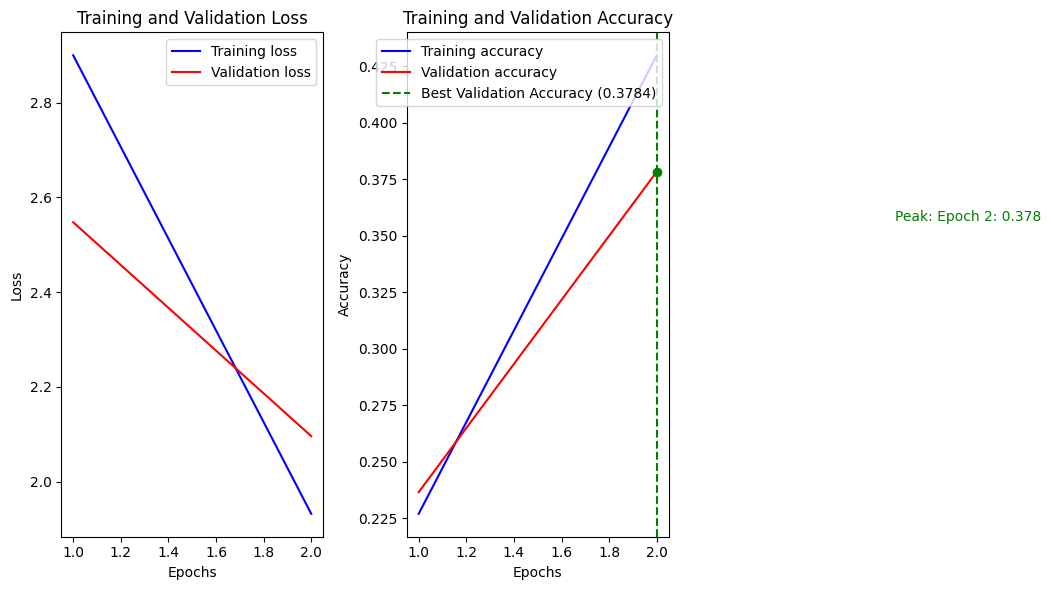

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register count_relu() for <class 'torch.nn.modules.activation.LeakyReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Directory 'saved_weights_1' created successfully


Epoch 1/2: 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]


Epoch 1/2
Train Loss: 2.7190 Train Accuracy: 0.2716
Val Loss: 2.7234 Val Accuracy: 0.2703
Saved best model weights with validation accuracy: 0.2703


Epoch 2/2: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


Epoch 2/2
Train Loss: 1.8959 Train Accuracy: 0.4436
Val Loss: 2.0611 Val Accuracy: 0.4054
Saved best model weights with validation accuracy: 0.4054


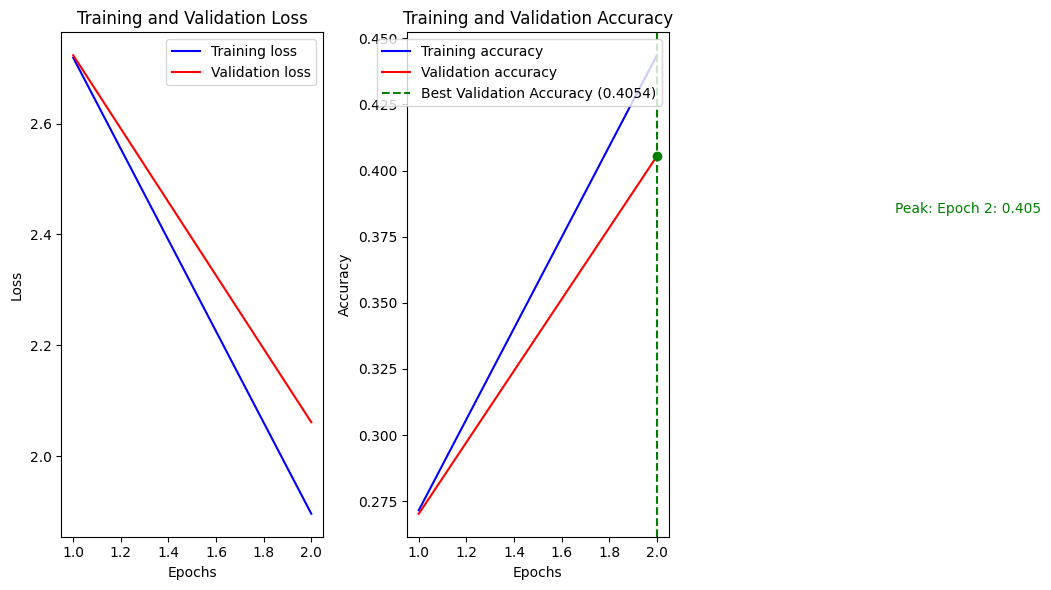

TypeError: DataFrame.__init__() got an unexpected keyword argument 'column'

In [132]:
cnf1 = update_config(cnf, 'num_stages', 3)
cnf2 = update_config(cnf, 'dropout_head', 0.0)
cnf3 = update_config(cnf, 'dropout_fe', 0.0)
cnf4 = update_config(cnf, 'stem_layer',stem_layer_2)
cnf5 = update_config(cnf, 'normalization', lambda channels: torch.nn.Identity(channels))
cnf6 = update_config(cnf, 'train_transform',  val_transform(resize_size, crop_size, mean, std))
cnfs = {'base_model': cnf,
        'minus one stage': cnf1,
        #'without head dropout': cnf2,
        #'without fe dropout': cnf3,
        #'7x7 stem': cnf4,
        #'no batchnorm': cnf5,
        #'no data agumentation': cnf6
        }
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
directory_path = 'saved_weights'
res = []
for idx, (conf_name, cnf) in enumerate(cnfs.items()):
    acc_value, flops, params = execute(cnf, device, f'{directory_path}_{idx}')
    res.append([conf_name, acc_value, flops, params])
print(pd.DataFrame(res, columns = ['model_name', 'best_val_acc', 'flops', 'n_params']))

In [49]:
summary(model, input_size=(3, crop_size, crop_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
         LeakyReLU-3         [-1, 64, 128, 128]               0
         ConvBlock-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          36,928
       BatchNorm2d-6         [-1, 64, 128, 128]             128
         LeakyReLU-7         [-1, 64, 128, 128]               0
         ConvBlock-8         [-1, 64, 128, 128]               0
            Conv2d-9         [-1, 64, 128, 128]          36,928
      BatchNorm2d-10         [-1, 64, 128, 128]             128
        LeakyReLU-11         [-1, 64, 128, 128]               0
        ConvBlock-12         [-1, 64, 128, 128]               0
        MaxPool2d-13           [-1, 64, 64, 64]               0
           Conv2d-14           [-1, 32,

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

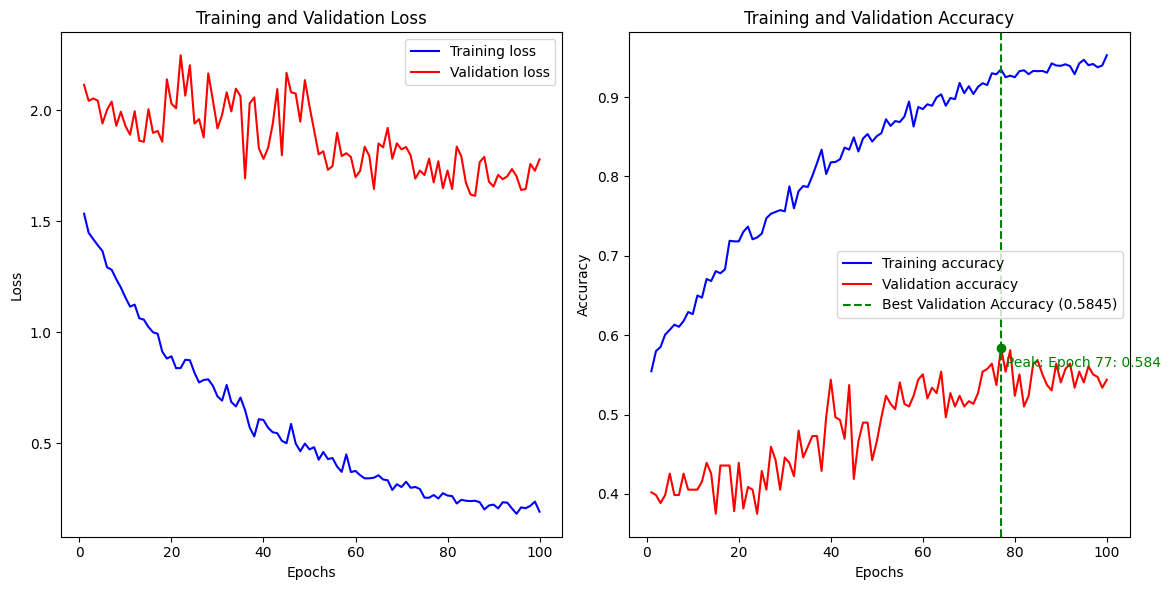

In [ ]:
plot_training_history(history)